In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import scipy.stats as stats
import statsmodels.api as sm

ModuleNotFoundError: No module named 'ace_tools'

In [2]:
df = pd.read_csv('D:\GitHub\MSc-Project\SWaT DataSWaT 2015-12-23.csv')

In [3]:
!nvcc --version

'nvcc' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
df.head()

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,date,time
0,2015-12-23 00:00:00,0.0,0.994030,0.5,1.0,0.0,0.509983,0.197627,0.500754,0.769136,...,0.0,0.958717,0.279476,0.962447,0.0,0.0,0.0,0.0,2015-12-23,00:00:00
1,2015-12-23 00:00:01,0.0,0.993523,0.5,1.0,0.0,0.509983,0.197627,0.501658,0.863706,...,0.0,0.958466,0.279476,0.962447,0.0,0.0,0.0,0.0,2015-12-23,00:00:01
2,2015-12-23 00:00:02,0.0,0.993523,0.5,1.0,0.0,0.509983,0.197627,0.503767,0.916761,...,0.0,0.957840,0.279476,0.962366,0.0,0.0,0.0,0.0,2015-12-23,00:00:02
3,2015-12-23 00:00:03,0.0,0.993467,0.5,1.0,0.0,0.494624,0.194993,0.506178,0.952045,...,0.0,0.957840,0.279476,0.961636,0.0,0.0,0.0,0.0,2015-12-23,00:00:03
4,2015-12-23 00:00:04,0.0,0.993072,0.5,1.0,0.0,0.494624,0.194993,0.509593,0.974452,...,0.0,0.958654,0.279476,0.961636,0.0,0.0,0.0,0.0,2015-12-23,00:00:04


In [5]:
def doFourierAnalysis(df, column_name):
    """
    Performs Fourier analysis on named column in the passed DataFrame, plots the power spectrum against the frequency bins.

    The plot is displayed on logarithmic scaled axis.

    Parameters:
    df (pandas.DataFrame): Sensor values DataFrame.
    column_name (str): The name of the column to analyze.

    Returns:
    None
    """
    # Extract the data from the DataFrame
    data = df[column_name].values

    # Number of data points
    N = len(data)

    # Compute the Fast Fourier Transform (FFT)
    fft_data = np.fft.fft(data)

    # Compute the Power Spectrum (magnitude of the FFT squared)
    power_spectrum = np.abs(fft_data) ** 2

    # Compute the frequency bins
    # If you have a time step dt between data points, replace 1.0 with dt in the line below
    freq = np.fft.fftfreq(N, 10.0)

    return (freq, power_spectrum)



In [6]:

def performFourierAndLimitHarmonics(df, column_name, num_harmonics):

    data = df[column_name].values

    # Perform the Fast Fourier Transform (FFT)
    fft_data = np.fft.fft(data)
    N = len(data)

    # Compute the magnitude of the FFT and find the indices of the largest components
    magnitudes = np.abs(fft_data)
    indices = np.argsort(magnitudes)[::-1]  # Sort indices by magnitude in descending order

    # Zero out all but the largest `num_harmonics` components
    fft_data_limited = np.zeros(N, dtype=complex)
    for i in range(num_harmonics):
        index = indices[i]
        fft_data_limited[index] = fft_data[index]

    # Inverse FFT to reconstruct the signal with limited harmonics
    reconstructed_signal = np.fft.ifft(fft_data_limited)

    return reconstructed_signal, fft_data_limited




In [7]:
def plot_columns(df, columns_list):

    # Convert the 'time' column to datetime if it's not already in that format
    if df['time'].dtype == object:
        df['time'] = pd.to_datetime(df['time'])

    # Set the size of the plot
    plt.figure(figsize=(12, 6))

    # Loop through the columns and plot each one
    for column in columns_list:
        plt.plot(df['time'], df[column], label=column)

    # Add title and labels
    plt.title('Signals Over Time')
    plt.xlabel('Time')
    plt.yscale('log')
    plt.ylabel('Signal Value')

    # set y range to plot if passed
    plt.ylim( 0.1, 1)

    # Show legend
    plt.legend()

    # Show grid
    plt.grid(True)

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()


In [8]:
def prep_data(df: pd.DataFrame, columns_list: list, start_time: str= None, end_time: str= None) -> pd.DataFrame:
    '''
    :param df: df of scaled results for a single date
    :param columns_list: columns to keep includingtime column
    :param start_time: string in format 'hh:mm:ss', default takes min value in df
    :param end_time: string in format 'hh:mm:ss', default takes max value in df
    :return: df of only values in time windo for specified columns
    '''

    # get times if not passed
    if start_time is None:
        start_time = df['time'].min()
    #else:
    #    start_time = pd.to_datetime(start_time)
    #    print(type(start_time))
    if end_time is None:
        end_time = df['time'].max()
    #else:
    #    end_time = pd.to_datetime(end_time)

    # filter to rows in time window
    df = df[(df['time'] >= start_time) & (df['time'] <= end_time)]
    df = df[columns_list]
    df_prepped = df.copy()

    # replace low values possibly to tidy graph

    return df_prepped


In [9]:
columns_list = ['time', 'MV101','LIT101','FIT101','P101','FIT201','MV201']

In [28]:
df_prepped = prep_data(df, columns_list, start_time= '00:00:00', end_time= '08:00:00')

In [29]:
columns_to_plot = ['MV101','LIT101','FIT101','P101','FIT201','MV201']

In [30]:
df_prepped.head()
# df.columns

,time,MV101,LIT101,FIT101,P101,FIT201,MV201
0,00:00:00,0.5,0.994030,0.0,1.0,0.769136,1.0
1,00:00:01,0.5,0.993523,0.0,1.0,0.863706,1.0
2,00:00:02,0.5,0.993523,0.0,1.0,0.916761,1.0
3,00:00:03,0.5,0.993467,0.0,1.0,0.952045,1.0
4,00:00:04,0.5,0.993072,0.0,1.0,0.974452,1.0


In [13]:
#df.head()

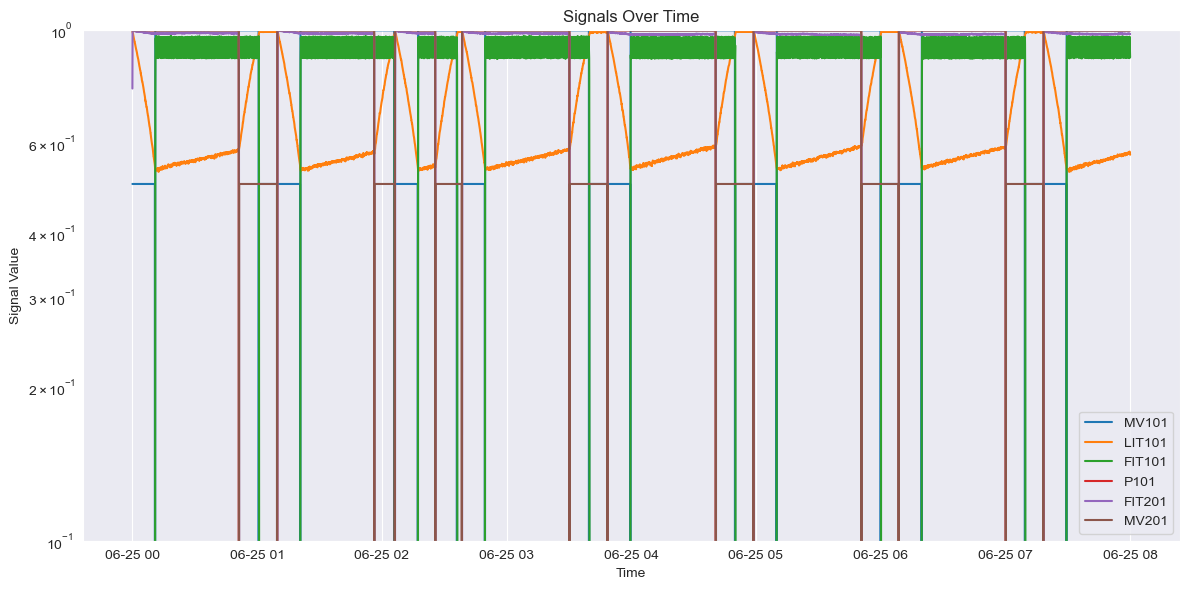

In [14]:
plot_columns(df_prepped, columns_to_plot)

C:\Users\laure\AppData\Local\Temp\ipykernel_20808\2441502937.py:26: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, np.max(freq))  # Limit x-axis to non-negative frequencies


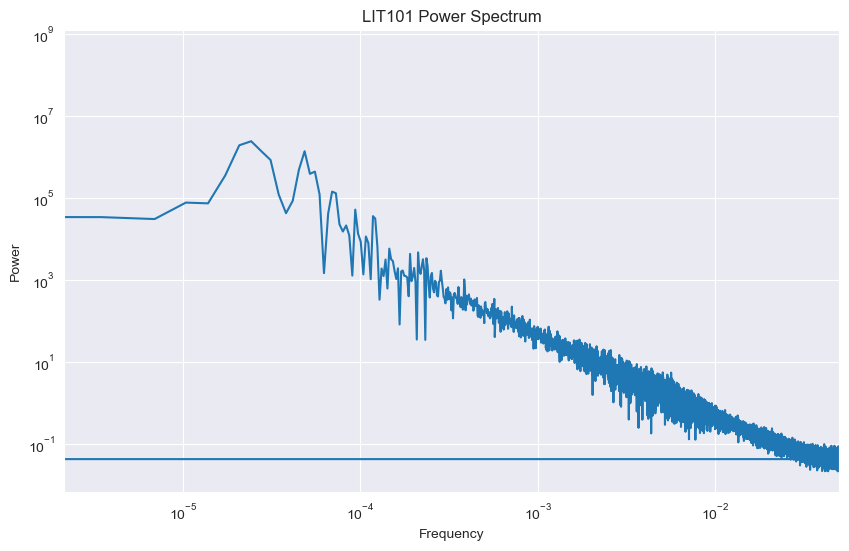

TypeError: cannot unpack non-iterable NoneType object

In [16]:
freq, power_spectrum = doFourierAnalysis(df_prepped, 'LIT101')

# Plotting the Power Spectrum
plt.figure(figsize=(10, 6))
plt.plot(freq, power_spectrum)
plt.title(f'{column_name} Power Spectrum')
plt.xscale('log')
plt.xlabel('Frequency')
plt.yscale('log')
plt.ylabel('Power')
plt.xlim(0, np.max(freq))  # Limit x-axis to non-negative frequencies
plt.show()

C:\Users\laure\AppData\Local\Temp\ipykernel_20808\2441502937.py:26: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, np.max(freq))  # Limit x-axis to non-negative frequencies


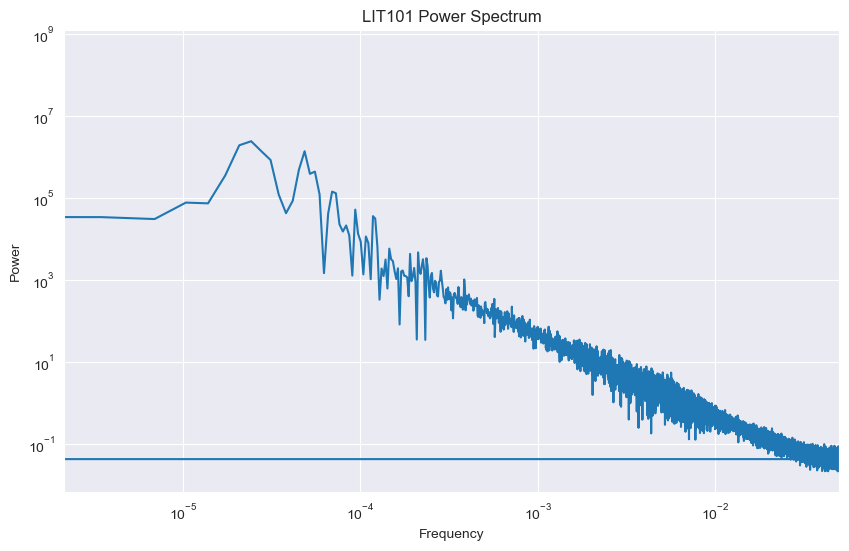

TypeError: cannot unpack non-iterable NoneType object

In [26]:
# Assuming df_prepped is already defined and contains 'LIT101' and 'FIT101' columns
freq_lit101, power_spectrum_lit101 = doFourierAnalysis(df_prepped, 'LIT101')
freq_fit101, power_spectrum_fit101 = doFourierAnalysis(df_prepped, 'FIT101')

# Plotting the Power Spectrum for both 'LIT101' and 'FIT101'
plt.figure(figsize=(10, 6))
plt.plot(freq_lit101, power_spectrum_lit101, label='LIT101')
plt.plot(freq_fit101, power_spectrum_fit101, label='FIT101', linestyle='--')
plt.title('Power Spectrum')
plt.xscale('log')
plt.xlabel('Frequency')
plt.yscale('log')
plt.ylabel('Power')
plt.xlim(0, np.max(freq_lit101))  # Limit x-axis to non-negative frequencies
plt.legend()
plt.show()

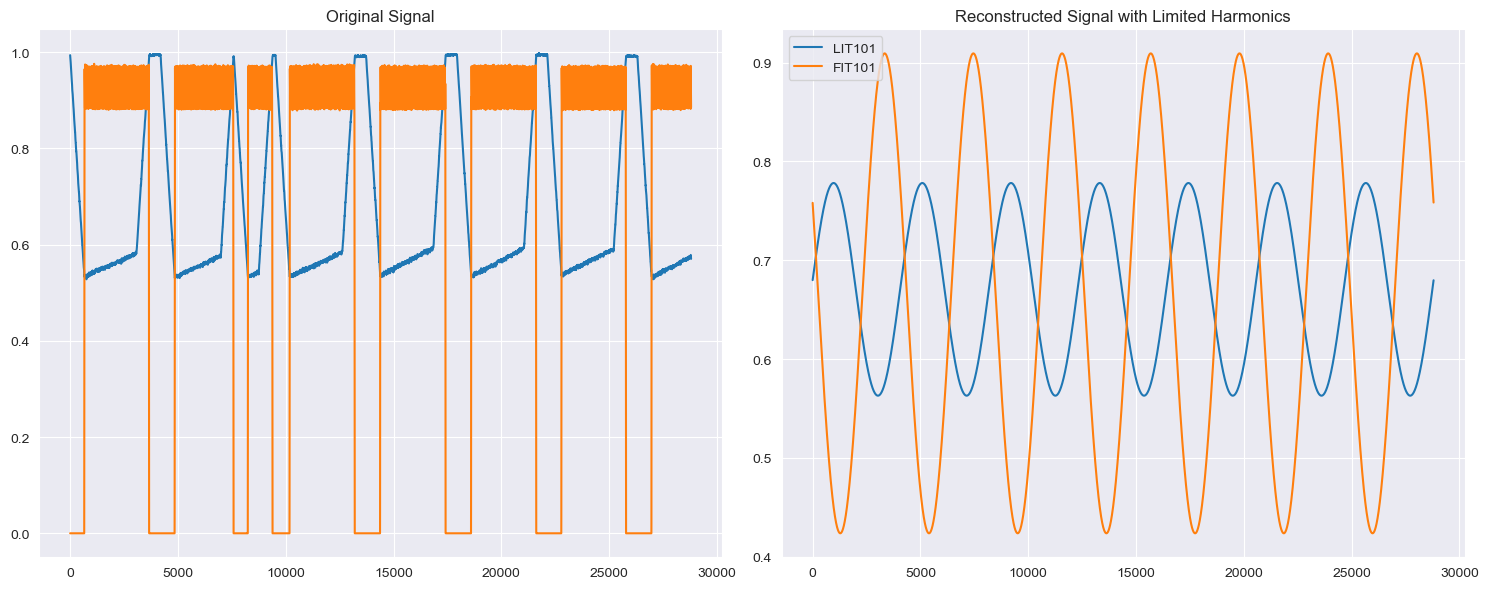

In [34]:
column_name_1 = 'LIT101'
column_name_2 = 'FIT101'
# Example usage:
# signal is your input signal, num_harmonics is the number of harmonics you want to keep
reconstructed_signal_1, limited_fft_data = performFourierAndLimitHarmonics(df_prepped, column_name_1, num_harmonics=3)
reconstructed_signal_2, limited_fft_data = performFourierAndLimitHarmonics(df_prepped, column_name_2, num_harmonics=3)
col_1 = df_prepped[column_name_1].values
col_2 = df_prepped[column_name_2].values
# Plot original and reconstructed signals
plt.figure(figsize=(15, 6))

# Original Signal
plt.subplot(1, 2, 1)
plt.plot(col_1, label= column_name_1)
plt.plot(col_2, label= column_name_2)
plt.title('Original Signal')

# Reconstructed Signal with Limited Harmonics
plt.subplot(1, 2, 2)
plt.plot(reconstructed_signal_1.real, label= 'LIT101')  # Take the real part since the output is complex
plt.plot(reconstructed_signal_2.real,label= 'FIT101')  # Take the real part since the output is complex
plt.title('Reconstructed Signal with Limited Harmonics')

plt.tight_layout()
plt.legend()
plt.show()


In [22]:
# find time difference between peaks


array([5.        , 5.58880346, 5.9518317 , 5.94988243, 5.5837031 ,
       4.99370426, 4.40611951, 4.04625676, 4.05210449, 4.4214204 ,
       5.01259122, 5.59893397, 5.95561698, 5.94587102, 5.57343317,
       4.98111379, 4.39603628, 4.04254716, 4.05619096, 4.43173599,
       5.02518045, 5.60896952, 5.95925075, 5.94170965, 5.56307233,
       4.96852631, 4.38604881, 4.03898936, 4.06042706, 4.44214168,
       5.03776568, 5.61890853, 5.96273243, 5.93739898, 5.55262221,
       4.95594383, 4.37615867, 4.03558393, 4.06481214, 4.45263581,
       5.05034492, 5.6287494 , 5.96606148, 5.93293968, 5.54208448,
       4.94336832, 4.36636744, 4.0323314 , 4.06934548, 4.46321672,
       5.06291619, 5.63849059, 5.96923737, 5.92833248, 5.5314608 ,
       4.9308018 , 4.35667668, 4.02923229, 4.07402637, 4.47388274,
       5.07547747, 5.64813056, 5.97225958, 5.92357809, 5.52075286,
       4.91824625, 4.3470879 , 4.02628708, 4.07885407, 4.48463218,
       5.0880268 , 5.65766776, 5.97512765, 5.91867727, 5.50996

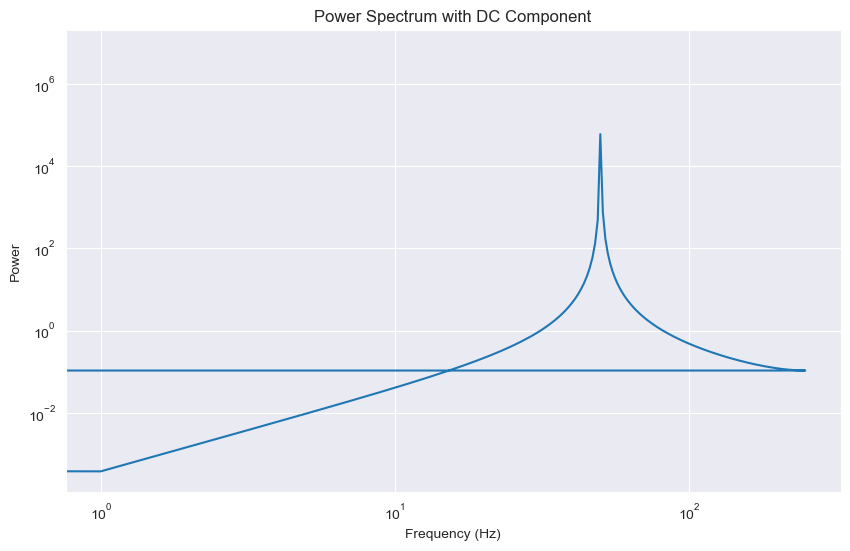

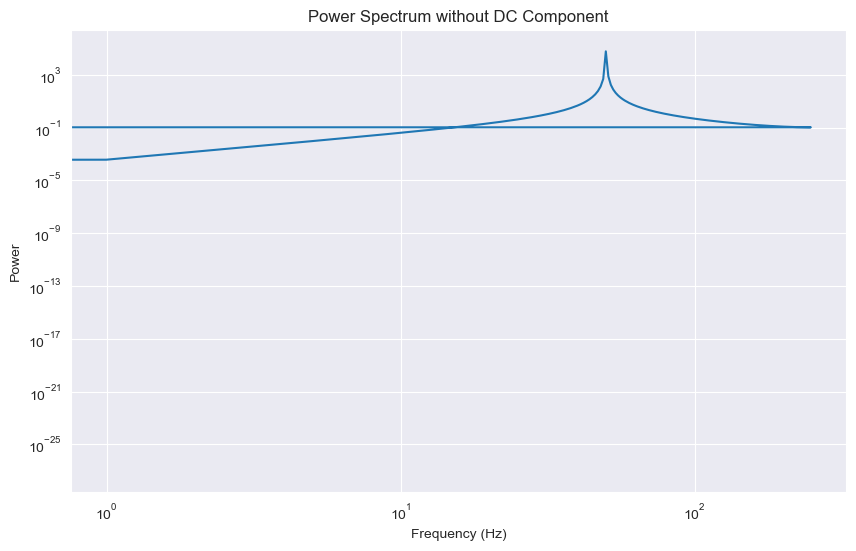

In [20]:
# effect of dc component
# Create a sample signal with a DC component
t = np.linspace(0, 1, 500)
signal = 5 + np.sin(2 * np.pi * 50 * t)  # DC component of 5

# Compute the FFT
fft_data = np.fft.fft(signal)
power_spectrum = np.abs(fft_data) ** 2
freq = np.fft.fftfreq(len(t), t[1] - t[0])

# Plot the Power Spectrum
plt.figure(figsize=(10, 6))
plt.plot(freq, power_spectrum)
plt.title('Power Spectrum with DC Component')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.xscale('log')
plt.yscale('log')
plt.show()

# Remove the DC component
signal_detrended = signal - np.mean(signal)

# Compute the FFT without the DC component
fft_data_detrended = np.fft.fft(signal_detrended)
power_spectrum_detrended = np.abs(fft_data_detrended) ** 2

# Plot the Power Spectrum without DC Component
plt.figure(figsize=(10, 6))
plt.plot(freq, power_spectrum_detrended)
plt.title('Power Spectrum without DC Component')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.xscale('log')
plt.yscale('log')
plt.show()

C:\Users\laure\AppData\Local\Temp\ipykernel_20808\50696631.py:58: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, np.max(freq_lit101))  # Limit x-axis to non-negative frequencies


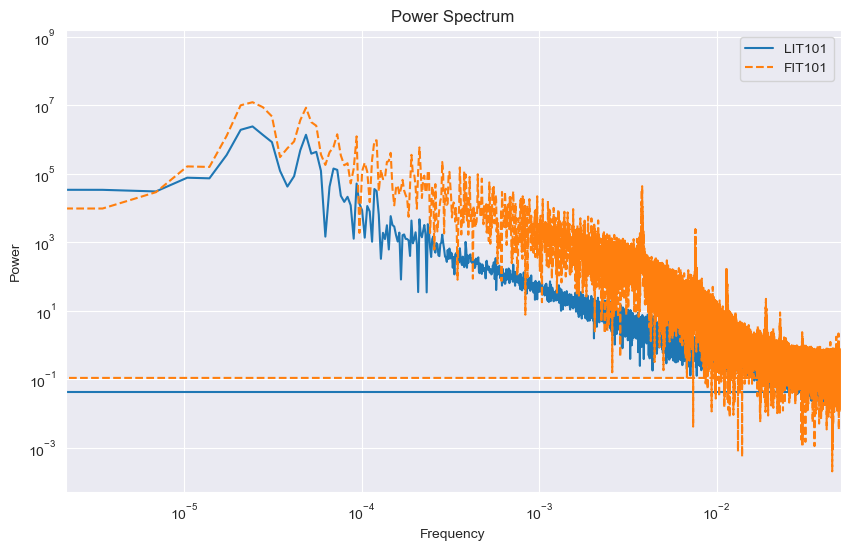

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def doFourierAnalysis(df, column_name):
    """
    Perform Fourier analysis on a specified column of a DataFrame and return the frequency bins and power spectrum.

    This function computes the Fast Fourier Transform (FFT) of the data in the specified column,
    calculates the power spectrum, and returns the power spectrum along with the frequency bins.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the data to analyze.
    column_name (str): The name of the column in the DataFrame to analyze.

    Returns:
    tuple: A tuple containing the frequency bins and the power spectrum.
    """
    # Extract the data from the DataFrame
    data = df[column_name].values

    # Number of data points
    N = len(data)

    # Compute the Fast Fourier Transform (FFT)
    fft_data = np.fft.fft(data)

    # Compute the Power Spectrum (magnitude of the FFT squared)
    power_spectrum = np.abs(fft_data) ** 2

    # Compute the frequency bins
    # If you have a time step dt between data points, replace 10.0 with dt in the line below
    freq = np.fft.fftfreq(N, 10.0)

    return freq, power_spectrum

# Sample DataFrame creation for testing
data = {
    'time': np.linspace(0, 1, 500),
    'LIT101': 5 + np.sin(2 * np.pi * 50 * np.linspace(0, 1, 500)),
    'FIT101': 3 + np.sin(2 * np.pi * 60 * np.linspace(0, 1, 500))
}
#df_prepped = pd.DataFrame(data)

# Perform Fourier analysis on the 'LIT101' and 'FIT101' columns
freq_lit101, power_spectrum_lit101 = doFourierAnalysis(df_prepped, 'LIT101')
freq_fit101, power_spectrum_fit101 = doFourierAnalysis(df_prepped, 'FIT101')

# Plotting the Power Spectrum for both 'LIT101' and 'FIT101'
plt.figure(figsize=(10, 6))
plt.plot(freq_lit101, power_spectrum_lit101, label='LIT101')
plt.plot(freq_fit101, power_spectrum_fit101, label='FIT101', linestyle='--')
plt.title('Power Spectrum')
plt.xscale('log')
plt.xlabel('Frequency')
plt.yscale('log')
plt.ylabel('Power')
plt.xlim(0, np.max(freq_lit101))  # Limit x-axis to non-negative frequencies
plt.legend()
plt.show()


C:\Users\laure\AppData\Local\Temp\ipykernel_20808\297213094.py:86: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, np.max(freq_lit101))  # Limit x-axis to non-negative frequencies


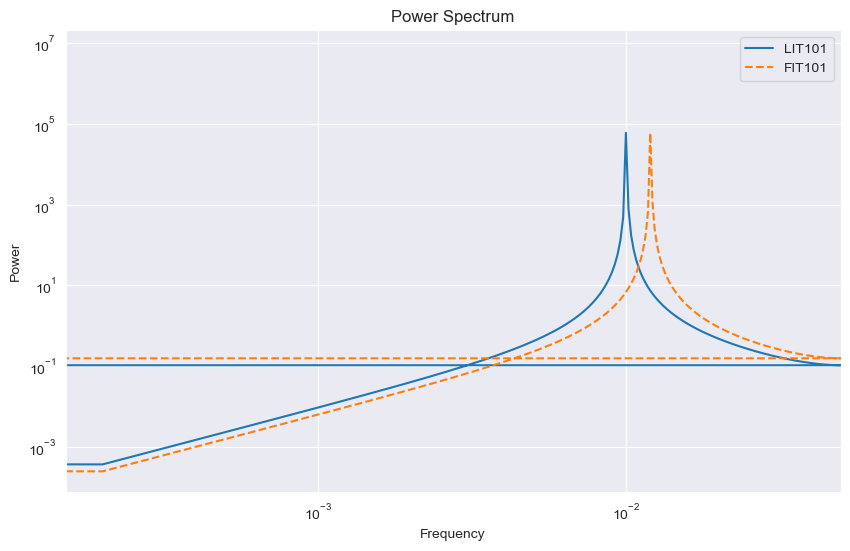

Harmonic Time Differences for LIT101:
Harmonic 2 (0.02) Hz: 50.00000 seconds
Harmonic 3 (0.03) Hz: 33.33333 seconds
Harmonic 4 (0.04) Hz: 25.00000 seconds
Harmonic 5 (0.05) Hz: 20.00000 seconds

Harmonic Time Differences for FIT101:
Harmonic 2 (0.024) Hz: 41.66667 seconds
Harmonic 3 (0.036000000000000004) Hz: 27.77778 seconds
Harmonic 4 (0.048) Hz: 20.83333 seconds
Harmonic 5 (0.06) Hz: 16.66667 seconds


In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def doFourierAnalysis(df, column_name, dt=10.0):
    """
    Perform Fourier analysis on a specified column of a DataFrame and return the frequency bins and power spectrum.

    This function computes the Fast Fourier Transform (FFT) of the data in the specified column,
    calculates the power spectrum, and returns the power spectrum along with the frequency bins.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the data to analyze.
    column_name (str): The name of the column in the DataFrame to analyze.
    dt (float): The time step between data points.

    Returns:
    tuple: A tuple containing the frequency bins and the power spectrum.
    """
    # Extract the data from the DataFrame
    data = df[column_name].values

    # Number of data points
    N = len(data)

    # Compute the Fast Fourier Transform (FFT)
    fft_data = np.fft.fft(data)

    # Compute the Power Spectrum (magnitude of the FFT squared)
    power_spectrum = np.abs(fft_data) ** 2

    # Compute the frequency bins
    freq = np.fft.fftfreq(N, dt)

    return freq, power_spectrum

def get_harmonic_time_differences(df, column_name, dt=10.0):
    """
    Calculate the time differences between peak values of the signal for the harmonics.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the data to analyze.
    column_name (str): The name of the column in the DataFrame to analyze.
    dt (float): The time step between data points.

    Returns:
    dict: A dictionary containing the harmonic frequencies and their corresponding time differences.
    """
    # Perform Fourier analysis
    freq, power_spectrum = doFourierAnalysis(df, column_name, dt)

    # Find the peak frequency (fundamental frequency)
    peak_indices, _ = find_peaks(power_spectrum)
    peak_freq = freq[peak_indices[np.argmax(power_spectrum[peak_indices])]]
    fundamental_period = 1 / peak_freq

    # Identify harmonics
    harmonics = [peak_freq * n for n in range(2, 6)]  # First four harmonics

    # Calculate time differences
    time_differences = {f"Harmonic {n} ({harm}) Hz": fundamental_period / n for n, harm in enumerate(harmonics, start=2)}

    return time_differences

# Sample DataFrame creation for testing
data = {
    'time': np.linspace(0, 1, 500),
    'LIT101': 5 + np.sin(2 * np.pi * 50 * np.linspace(0, 1, 500)),
    'FIT101': 3 + np.sin(2 * np.pi * 60 * np.linspace(0, 1, 500))
}
df_prepped = pd.DataFrame(data)

# Perform Fourier analysis and plot power spectrum
freq_lit101, power_spectrum_lit101 = doFourierAnalysis(df_prepped, 'LIT101')
freq_fit101, power_spectrum_fit101 = doFourierAnalysis(df_prepped, 'FIT101')

plt.figure(figsize=(10, 6))
plt.plot(freq_lit101, power_spectrum_lit101, label='LIT101')
plt.plot(freq_fit101, power_spectrum_fit101, label='FIT101', linestyle='--')
plt.title('Power Spectrum')
plt.xscale('log')
plt.xlabel('Frequency')
plt.yscale('log')
plt.ylabel('Power')
plt.xlim(0, np.max(freq_lit101))  # Limit x-axis to non-negative frequencies
plt.legend()
plt.show()

# Get time differences for harmonics
time_differences_lit101 = get_harmonic_time_differences(df_prepped, 'LIT101')
time_differences_fit101 = get_harmonic_time_differences(df_prepped, 'FIT101')

# Display the results
print("Harmonic Time Differences for LIT101:")
for harmonic, time_diff in time_differences_lit101.items():
    print(f"{harmonic}: {time_diff:.5f} seconds")

print("\nHarmonic Time Differences for FIT101:")
for harmonic, time_diff in time_differences_fit101.items():
    print(f"{harmonic}: {time_diff:.5f} seconds")
